# TP Phase 


#### Nous traitons ici les distance sur la phase par la méthode de double différences

Importation des librairies : 

In [1]:
import re
import pandas as pd
import numpy as np
import geodezyx
import geodezyx.conv as conv
import gpsdatetime as gpst
import gnsstoolbox.orbits as orb
import gnsstoolbox.gnss_const as gnss_const
import gnsstoolbox.gnsstools as tools
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

250309T11:26:21.127|W|leapseconds_harcoded_list|Harcoded leap second list loaded
It might be wrong if IERS's bulletin C has been updated!
last known update: (datetime.datetime(2017, 1, 1, 0, 0), 27)


Fonction pour gener les data frame à partir des rinex : 

In [2]:
def grep_file(pattern, filename):
    """Recherche un motif dans un fichier et retourne les lignes correspondantes."""
    results = []
    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            if re.search(pattern, line):
                results.append(line.strip())
    return results



def create_dataframe_from_rinex(rinex_file, sp3_files, brdc_file):
    """
    Crée un DataFrame à partir d'un fichier RINEX d'observation.

    Args:
        rinex_file (str): Chemin du fichier RINEX d'observation.
        sp3_files (list): Liste des chemins des fichiers SP3 pour les orbites.
        brdc_file (str): Chemin du fichier de navigation RINEX.

    Returns:
        pd.DataFrame: DataFrame contenant les données nettoyées et enrichies.
        np.ndarray: Position approximative du récepteur (X, Y, Z).
    """
    # Chargement des données RINEX d'observation
    df_rnx = geodezyx.files_rw.read_rinex_obs(rinex_file, set_index=['epoch', 'prn'])

    # Nettoyage des données
    df_rnx = df_rnx.dropna(axis=1, how='all')
    
    # Vérification de la présence de P2
    required_cols = ['C1', 'L1', 'L2']  # Colonnes minimales nécessaires
    if 'P2' in df_rnx.columns:
        required_cols.append('P2')  # Ajouter P2 si disponible
    else:
        print(f"Attention : 'P2' non disponible dans {rinex_file}. Utilisation de 'C1' comme approximation pour P2.")
        df_rnx['P2'] = df_rnx['C1']  # Approximation si P2 absent
        required_cols.append('P2')

    # Suppression des lignes avec NaN dans les colonnes requises
    rows_with_nan = df_rnx[required_cols].isna().any(axis=1)
    df_rnx = df_rnx.dropna(subset=required_cols)

    # Filtrage des satellites GPS
    df_rnx = df_rnx[df_rnx['sys'].str.contains('G')]
    df_rnx['ind_ligne'] = range(len(df_rnx))

    # Extraction de la position approximative du récepteur
    columns = grep_file(r"APPROX POSITION XYZ", rinex_file)
    if columns:
        valeurs = columns[0].split()[:3]
        P_rnx_header = np.array(valeurs, dtype=float)
        print("Coordonnées XYZ :", P_rnx_header)
    else:
        print("Aucune correspondance trouvée.")
        P_rnx_header = np.array([0, 0, 0], dtype=float)

    # Chargement des fichiers d'orbites
    mysp3 = orb.orbit()
    for sp3_file in sp3_files:
        mysp3.loadSp3(sp3_file)

    mynav = orb.orbit()
    mynav.loadRinexN(brdc_file)

    # Calcul des positions des satellites et des corrections relativistes
    t = gpst.gpsdatetime()
    X_sat, Y_sat, Z_sat, dte_sat, dRelat = [], [], [], [], []

    for (time_i, prn_i) in df_rnx.index:
        t.rinex_t(time_i.to_pydatetime().strftime('%y %m %d %H %M %S.%f'))
        t_emission_mjd = t.mjd - df_rnx.loc[(time_i, prn_i), 'C1'] / gnss_const.c / 86400.0
        
        (X_sat_v, Y_sat_v, Z_sat_v, dte_sat_v) = mysp3.calcSatCoord(prn_i[0], int(prn_i[1:]), t_emission_mjd)
        
        # Calcul de l'effet relativiste
        delta_t = 1e-3
        (Xs1, Ys1, Zs1, clocks1) = mysp3.calcSatCoord(prn_i[0], int(prn_i[1:]), t_emission_mjd - delta_t / 86400.0)
        (Xs2, Ys2, Zs2, clocks2) = mysp3.calcSatCoord(prn_i[0], int(prn_i[1:]), t_emission_mjd + delta_t / 86400.0)
        
        VX = (np.array([Xs2 - Xs1, Ys2 - Ys1, Zs2 - Zs1])) / 2.0 / delta_t
        VX0 = np.array([X_sat_v, Y_sat_v, Z_sat_v])
        dRelat_v = -2.0 * VX0.T @ VX / (gnss_const.c ** 2)
        
        # Correction du temps d'émission
        t_emission_mjd = t_emission_mjd - dte_sat_v / 86400.0 - dRelat_v / 86400.0
        (X_sat_v, Y_sat_v, Z_sat_v, dte_sat_v) = mysp3.calcSatCoord(prn_i[0], int(prn_i[1:]), t_emission_mjd)
        
        X_sat.append(X_sat_v)
        Y_sat.append(Y_sat_v)
        Z_sat.append(Z_sat_v)
        dte_sat.append(dte_sat_v)
        dRelat.append(dRelat_v)

    # Ajout des colonnes au DataFrame
    df_rnx['X_sat'] = X_sat
    df_rnx['Y_sat'] = Y_sat
    df_rnx['Z_sat'] = Z_sat
    df_rnx['dte_sat'] = dte_sat
    df_rnx['dRelat'] = dRelat

    return df_rnx, P_rnx_header

Chemins des données : 

In [3]:
rinex_fileKnown = 'PPMD_2025/mlvl176z.18o'
sp3_files = [
    'PPMD_2025/igs20071.sp3',
    'PPMD_2025/igs20072.sp3'
]
brdc_fileKnow = 'PPMD_2025/mlvl176z.18n'

rinex_fileUnknown = 'PPMD_2025/smne176z.18o'
brdc_fileUnknown = 'PPMD_2025/smne176z.18n'

In [4]:
df_rnxKnown, P_rnx_header = create_dataframe_from_rinex(rinex_fileKnown, sp3_files, brdc_fileKnow)
df_rnxUnknown,  P_rnx_header_Unknown= create_dataframe_from_rinex(rinex_fileUnknown, sp3_files, brdc_fileUnknown)

Reading mlvl176z.18o: 100%|██████████| 120/120 [00:00<00:00, 790.86it/s]


Coordonnées XYZ : [4201577.209  189859.856 4779064.567]
Loading SP3 file PPMD_2025/igs20071.sp3. --> ok
Loading SP3 file PPMD_2025/igs20072.sp3. --> ok
Loading RINEX nav file PPMD_2025/mlvl176z.18n --> ok


Reading smne176z.18o: 100%|██████████| 120/120 [00:00<00:00, 848.63it/s]


Coordonnées XYZ : [4201792.295  177945.238 4779286.685]
Loading SP3 file PPMD_2025/igs20071.sp3. --> ok
Loading SP3 file PPMD_2025/igs20072.sp3. --> ok
Loading RINEX nav file PPMD_2025/smne176z.18n --> ok


Prise en compte de l'effet Sagnac

In [5]:
def add_sagnac_correction(df, obs_column='P3'):
    """
    Ajoute les colonnes de correction de rotation (effet Sagnac) au DataFrame.

    Args:
        df (pd.DataFrame): DataFrame contenant les données des satellites.
        obs_column (str): Nom de la colonne contenant les observations (par défaut 'P3').

    Returns:
        pd.DataFrame: DataFrame avec les colonnes de rotation ajoutées.
        np.ndarray: Matrice des positions corrigées des satellites (X_sat_rot, Y_sat_rot, Z_sat_rot).
    """
    # Initialisation des colonnes de rotation
    df["X_sat_rot"] = df["X_sat"]
    df["Y_sat_rot"] = df["Y_sat"]
    df["Z_sat_rot"] = df["Z_sat"]

    # Application de la correction de rotation
    for index, row in df.iterrows():
        T_vol = row[obs_column] / gnss_const.c  # Temps de vol du signal
        angle_rot = T_vol * np.pi * 2 / (86164.096)  # Angle de rotation (effet Sagnac)
        
        # Rotation des coordonnées du satellite
        X, Y, Z = tools.toolRotZ(row['X_sat'], row['Y_sat'], row['Z_sat'], -angle_rot)
        
        # Mise à jour des colonnes de rotation
        df.at[index, 'X_sat_rot'] = X
        df.at[index, 'Y_sat_rot'] = Y
        df.at[index, 'Z_sat_rot'] = Z

    # Extraction des positions corrigées
    Xsat = df['X_sat_rot'].values
    Ysat = df['Y_sat_rot'].values
    Zsat = df['Z_sat_rot'].values
    PosSatSagn = np.column_stack((Xsat, Ysat, Zsat))

    return df, PosSatSagn

In [6]:
df_rnxKnown_new, PosSatSagn_Known = add_sagnac_correction(df_rnxKnown, obs_column='C1')
df_rnxUnknown_new, PosSatSagn_Unknown = add_sagnac_correction(df_rnxUnknown, obs_column='C1')
print(df_rnxKnown_new.shape)
print(df_rnxUnknown_new.shape)    
print(P_rnx_header.shape)
print(PosSatSagn_Unknown.shape)

(1148, 27)
(1137, 29)
(3,)
(1137, 3)


#### Combinaison Wilde lane et Narrow lane

In [7]:
# Constantes GNSS
f1 = gnss_const.f1  # Fréquence L1 : 1575.42 MHz 
f2 = gnss_const.f2  # Fréquence L2 : 1227.60 MHz 
c = gnss_const.c    

# Longueurs d'onde Wide-lane et Narrow-lane
lambda_w = c / (f1 - f2)  # ≈ 0.8618 m
lambda_n = c / (f1 + f2)  # ≈ 0.1070 m

In [8]:
def add_lane_combinations(df):
    """
    Ajoute les combinaisons Wide-lane, Narrow-lane et L1 au DataFrame en cycles et en mètres.
    
    Args:
        df (pd.DataFrame): DataFrame contenant les mesures de phase L1 et L2.
    
    Returns:
        pd.DataFrame: DataFrame avec les colonnes L1 (L1m), Wide-lane (L_W, L_W_m) et Narrow-lane (L_N, L_N_m).
    """
    # L1 en mètres
    df['L1m'] = df['L1'] * gnss_const.lambda1  # Conversion en mètres
    
    # Wide-lane en cycles et en mètres
    df['L_W'] = df['L1'] - df['L2']  # Combinaison en cycles
    df['L_W_m'] = df['L_W'] * lambda_w  # Conversion en mètres
    
    # Narrow-lane en cycles et en mètres
    df['L_N'] = df['L1'] + df['L2']  # Combinaison en cycles
    df['L_N_m'] = df['L_N'] * lambda_n  # Conversion en mètres
    
    return df

In [9]:


def compute_melbourne_wubbena(df_rnxKnown_new, df_rnxUnknown_new):
    common_index = df_rnxKnown_new.index.intersection(df_rnxUnknown_new.index)
    df_known = df_rnxKnown_new.loc[common_index].copy()
    df_unknown = df_rnxUnknown_new.loc[common_index].copy()
    
    df_known['MW'] = (df_known['L1'] - df_known['L2']) - (f1 * df_known['C1'] + f2 * df_known['P2']) / (f1 + f2) / lambda_w
    df_unknown['MW'] = (df_unknown['L1'] - df_unknown['L2']) - (f1 * df_unknown['C1'] + f2 * df_unknown['P2']) / (f1 + f2) / lambda_w
    
    epochs = np.unique(df_known.index.get_level_values('epoch'))
    all_prn = np.unique(df_known.index.get_level_values('prn'))
    prn_pivot = df_known.groupby('prn').filter(lambda x: len(x) == len(epochs)).groupby('prn')['ele'].mean().idxmax()
    
    MW_dd = []
    prn_list = []
    for epoch in epochs:
        df_epoch_known = df_known.loc[epoch]
        df_epoch_unknown = df_unknown.loc[epoch]
        mw_pivot_k = df_epoch_known.loc[prn_pivot, 'MW']
        mw_pivot_u = df_epoch_unknown.loc[prn_pivot, 'MW']
        for prn in df_epoch_known.index.get_level_values('prn'):
            if prn != prn_pivot:
                mw_k = df_epoch_known.loc[prn, 'MW']
                mw_u = df_epoch_unknown.loc[prn, 'MW']
                mw_dd = (mw_u - mw_k) - (mw_pivot_u - mw_pivot_k)
                MW_dd.append(mw_dd)
                prn_list.append(prn)
    
    MW_dd = np.array(MW_dd)
    prn_unique = np.unique(prn_list)
    N_W_float = np.zeros(len(prn_unique))
    N_W_std = np.zeros(len(prn_unique))
    for i, prn in enumerate(prn_unique):
        mask = np.array(prn_list) == prn
        mw_dd_prn = MW_dd[mask]
        N_W_float[i] = np.mean(mw_dd_prn)
        N_W_std[i] = np.std(mw_dd_prn) if len(mw_dd_prn) > 1 else 0
    
    # Filtrer les satellites avec écart-type > 1
    valid_mask = N_W_std < 1.0
    N_W_fixed = np.round(N_W_float[valid_mask]).astype(int)
    prn_unique_filtered = prn_unique[valid_mask]
    
    print(f"Ambiguïtés MW flottantes: {N_W_float}")
    print(f"Écart-type MW: {N_W_std}")
    print(f"Ambiguïtés MW fixées (filtrées): {N_W_fixed}")
    print(f"Satellites correspondants (filtrés): {prn_unique_filtered}")
    
    return N_W_fixed, prn_unique_filtered

In [10]:
df_rnxKnown_new = add_lane_combinations(df_rnxKnown_new)
df_rnxUnknown_new = add_lane_combinations(df_rnxUnknown_new)

#### Création du vecteur B

In [11]:
epochs = np.unique(df_rnxKnown_new.index.get_level_values('epoch')) # Liste des epochs

def createVecB(epochs, prn_pivot, indx_prn_pivot, df_rnxKnown_new, df_rnxUnknown_new, dist_known, dist_Unknown, phase_type='L1m'):
    """
    Crée le vecteur B pour la double différence avec une combinaison de phase spécifiée.
    
    Args:
        epochs: Liste des époques.
        prn_pivot: Satellite pivot.
        indx_prn_pivot: Index du satellite pivot.
        df_rnxKnown_new: DataFrame de la station connue.
        df_rnxUnknown_new: DataFrame de la station inconnue.
        dist_known: Distances géométriques pour la station connue.
        dist_Unknown: Distances géométriques pour la station inconnue.
        phase_type: Type de phase ('L1m', 'L_W_m', 'L_N_m').
    
    Returns:
        np.ndarray: Vecteur B.
    """
    B = np.zeros(len(df_rnxUnknown_new))
    for e, epch in enumerate(epochs):
        indx = df_rnxUnknown_new.index.get_level_values('epoch') == epch
        # Simple différence sur satellite pivot (scalaire)
        Diff_sat_pivot = df_rnxUnknown_new[phase_type][epch, prn_pivot] - df_rnxKnown_new[phase_type][epch, prn_pivot]
        # Simple différence sur tous les satellites (vecteur)
        Diff_sat = df_rnxUnknown_new[phase_type][indx] - df_rnxKnown_new[phase_type][indx]
        # Définition de l'observation
        B[indx] = Diff_sat_pivot - Diff_sat + dist_known[epch, prn_pivot] - dist_known[epch] - dist_Unknown[epch, prn_pivot] + dist_Unknown[epch]
    B = B[~indx_prn_pivot]
    return B


### Création Matrice A

In [12]:
all_prn = np.unique(df_rnxKnown_new.index.get_level_values('prn'))

def createMatA(epochs, prn_pivot, indx_prn_pivot, df_rnxUnknown_new, P_rnx_header, P_init, dist_Unknown, all_prn):
    A = np.zeros((len(df_rnxUnknown_new), 3 + len(all_prn)))  # 3 coordonnées + N ambiguïtés
    for e, epch in enumerate(epochs):
        indx = df_rnxUnknown_new.index.get_level_values('epoch') == epch
        A[indx, 0] = (P_init[0] - df_rnxUnknown_new['X_sat'][epch, prn_pivot]) / dist_Unknown[epch, prn_pivot] - \
                     (P_rnx_header[0] - df_rnxUnknown_new['X_sat'][epch]) / dist_Unknown[epch]
        A[indx, 1] = (P_init[1] - df_rnxUnknown_new['Y_sat'][epch, prn_pivot]) / dist_Unknown[epch, prn_pivot] - \
                     (P_rnx_header[1] - df_rnxUnknown_new['Y_sat'][epch]) / dist_Unknown[epch]
        A[indx, 2] = (P_init[2] - df_rnxUnknown_new['Z_sat'][epch, prn_pivot]) / dist_Unknown[epch, prn_pivot] - \
                     (P_rnx_header[2] - df_rnxUnknown_new['Z_sat'][epch]) / dist_Unknown[epch]
        for p, prn in enumerate(all_prn):
            if prn != prn_pivot:
                indx_prn = df_rnxUnknown_new.index.get_level_values('prn') == prn
                A[indx_prn, 3 + p] = 1
            else:
                column_index_to_remove = 3 + p
    A = A[~indx_prn_pivot]
    A = np.delete(A, column_index_to_remove, axis=1)
    return A

### Double difference 

- Nous allons calculer les position de la station inconnues grace àà la méthode de double différence à partir des observations de base d'une station connue en coordonnées.
Le doubles différences sont effectuées avec un satellite pivot qui est visible par les 2 stations. C'est celui qui présente donc l'élévation maximale et qui visible par la station connue en coordonnée et l'inconnue. L'estimation est réalisée par moindre carrée selon la méthode de Gauss-Newton. Cette dernière est choisi de part la non linéaritées des modèles de distance.
La double différence permet d'éliminer les erreurs d'horloges satellites dans un premier temps avec les simples différences, puis les erreurs d'horloge recepteurs. Cette dernière nous permet également de corriger les effets ionosphériques et troposphériques. 

In [13]:
def double_difference(df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L1m'):
    P0 = P_rnx_header_Unknown.reshape(-1, 1)  # Coordonnées initiales du récepteur inconnu
    print("P0 shape:", P0.shape)

    common_index = df_rnxKnown_new.index.intersection(df_rnxUnknown_new.index)
    df_rnxKnown_new = df_rnxKnown_new.loc[common_index].copy()
    df_rnxUnknown_new = df_rnxUnknown_new.loc[common_index].copy()
    all_prn = np.unique(df_rnxKnown_new.index.get_level_values('prn'))
    epochs = np.unique(df_rnxKnown_new.index.get_level_values('epoch'))

    # Calcul des élévations
    ele_unknown = []
    ele_known = []
    for epoch in epochs:
        df_epoch_unknown = df_rnxUnknown_new.loc[epoch]
        df_epoch_known = df_rnxKnown_new.loc[epoch]
        _, ele_k = tools.toolAzEle(P_rnx_header[0], P_rnx_header[1], P_rnx_header[2],
                                   df_epoch_known['X_sat'].values,
                                   df_epoch_known['Y_sat'].values,
                                   df_epoch_known['Z_sat'].values)
        ele_known.extend(ele_k)
        _, ele_u = tools.toolAzEle(P0[0, 0], P0[1, 0], P0[2, 0],
                                   df_epoch_unknown['X_sat'].values,
                                   df_epoch_unknown['Y_sat'].values,
                                   df_epoch_unknown['Z_sat'].values)
        ele_unknown.extend(ele_u)

    df_rnxUnknown_new['ele'] = ele_unknown
    df_rnxKnown_new['ele'] = ele_known

    # Boucle d'itération
    sigma02_old = 0
    sigma02 = 1e6
    cpt = 0

    while np.abs(sigma02_old - sigma02) > 1e-6:
        dist_known = np.sqrt((df_rnxKnown_new['X_sat'] - P_rnx_header[0])**2 +
                             (df_rnxKnown_new['Y_sat'] - P_rnx_header[1])**2 +
                             (df_rnxKnown_new['Z_sat'] - P_rnx_header[2])**2)
        dist_Unknown = np.sqrt((df_rnxUnknown_new['X_sat'] - P0[0])**2 +
                               (df_rnxUnknown_new['Y_sat'] - P0[1])**2 +
                               (df_rnxUnknown_new['Z_sat'] - P0[2])**2)

        prn_pivot = df_rnxKnown_new.groupby('prn').filter(lambda x: len(x) == len(epochs)).groupby('prn')['ele'].mean().idxmax()
        indx_prn_pivot = df_rnxUnknown_new.index.get_level_values('prn') == prn_pivot

        matA = createMatA(epochs, prn_pivot, indx_prn_pivot, df_rnxUnknown_new, P_rnx_header, P0, dist_Unknown, all_prn)
        matB = createVecB(epochs, prn_pivot, indx_prn_pivot, df_rnxKnown_new, df_rnxUnknown_new, dist_known, dist_Unknown, phase_type)
        W = np.eye(len(matB))

        dP = np.linalg.inv(matA.T @ W @ matA) @ matA.T @ W @ matB
        P_chap = P0 + dP[:3].reshape(-1, 1)
        Vchap = matB - matA @ dP
        Bchap = matA @ dP

        n = matA.shape[0]
        p = matA.shape[1]
        sigma02_old = sigma02
        sigma02 = (Vchap.T @ W @ Vchap) / (n - p)

        P0 = P_chap
        cpt += 1
        print(f'Iteration {cpt}: sigma02 = {sigma02}')

    SigmaP = sigma02 * np.linalg.inv(matA.T @ W @ matA)
    return P_chap, Vchap, sigma02, SigmaP, Bchap

# Ajout de L1m avant l'appel
df_rnxKnown_new['L1m'] = df_rnxKnown_new['L1'] * gnss_const.lambda1
df_rnxUnknown_new['L1m'] = df_rnxUnknown_new['L1'] * gnss_const.lambda1

# Appel corrigé


- Execution du code

In [14]:
# Avec L1 (original)
P_chap_L1, Vchap_L1, sigma02_L1, SigmaP_L1, Bchap_L1 = double_difference(
    df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L1m'
)
print("Résultat avec L1:", P_chap_L1)


P0 shape: (3, 1)
Iteration 1: sigma02 = 0.7768756234645808
Iteration 2: sigma02 = 0.7768753017126742
Résultat avec L1: [[4201791.68642587]
 [ 177946.54185155]
 [4779286.11530576]]


In [15]:
def plot_residual_analysis(B_est, V_est, figure_title=None, save_path=None):
    """
    Calcule les résidus (V_est = B - A @ dP_est) et trace une figure contenant :
      1. La série temporelle des résidus (affichée en points)
      2. L'histogramme des résidus (nombre d'observations par bin)
      3. Le Q-Q Plot des résidus
      4. Un scatter plot des résidus en fonction des valeurs prédites
      5. Un encart affichant quelques statistiques (moyenne, variance, écart-type, skewness, kurtosis)
    
    Paramètres :
      - A : array-like, matrice des variables explicatives
      - B : array-like, vecteur des observations
      - dP_est : array-like, vecteur des paramètres estimés
      - figure_title (optionnel) : str, titre global de la figure
      - save_path (optionnel) : str, chemin complet (avec nom et extension) pour sauvegarder la figure
      
    Renvoie :
      - fig : l'objet Figure de matplotlib contenant l'ensemble des graphiques
    """
    
   
    
    
    # Calcul des statistiques sur les résidus
    moyenne    = np.mean(V_est)
    variance   = np.var(V_est)
    ecart_type = np.std(V_est)
    skewness   = stats.skew(V_est)
    kurtosis   = stats.kurtosis(V_est)
    
    # Création d'une figure avec GridSpec : 3 lignes et 2 colonnes
    # La dernière ligne (row 2) est utilisée pour l'encart des statistiques et s'étend sur les 2 colonnes.
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.5])
    
    # 1. Série temporelle des résidus (affichage uniquement des points) – Top gauche
    ax_time = fig.add_subplot(gs[0, 0])
    ax_time.scatter(np.arange(len(V_est)), V_est, color='green')
    ax_time.set_title("Série temporelle des résidus")
    ax_time.set_xlabel("Temps / Index")
    ax_time.set_ylabel("Résidus")
    
    # 2. Histogramme des résidus (nombre brut d'observations) – Top droite
    ax_hist = fig.add_subplot(gs[0, 1])
    sns.histplot(V_est, bins=30, stat="count", color='skyblue', edgecolor='black', ax=ax_hist)
    ax_hist.set_title("Histogramme des résidus")
    ax_hist.set_xlabel("Résidus")
    ax_hist.set_ylabel("Nombre d'observations")
    
    # 3. Q-Q Plot des résidus – Milieu gauche
    ax_qq = fig.add_subplot(gs[1, 0])
    sm.qqplot(V_est, line='s', ax=ax_qq)
    ax_qq.set_title("Q-Q Plot des résidus")
    
    # 4. Graphique des résidus vs. valeurs prédites – Milieu droite
    ax_scatter = fig.add_subplot(gs[1, 1])
    ax_scatter.scatter(B_est, V_est, alpha=0.7, color='darkorange')
    ax_scatter.axhline(0, color='red', linestyle='--')
    ax_scatter.set_xlabel("Valeurs prédites")
    ax_scatter.set_ylabel("Résidus")
    ax_scatter.set_title("Résidus vs. Valeurs prédites")
    
    # 5. Encadré avec les statistiques – Bas, sur 2 colonnes
    ax_stats = fig.add_subplot(gs[2, :])
    ax_stats.axis('off')  # Masquer les axes pour cet encart
    texte_stats = (
        f"Moyenne    : {moyenne:.4f}\n"
        f"Variance   : {variance:.4f}\n"
        f"Écart-type : {ecart_type:.4f}\n"
        f"Skewness   : {skewness:.4f}\n"
        f"Kurtosis   : {kurtosis:.4f}"
    )
    ax_stats.text(0.5, 0.5, texte_stats, transform=ax_stats.transAxes,
                  fontsize=14, verticalalignment='center', horizontalalignment='center',
                  bbox=dict(facecolor='wheat', edgecolor='black', boxstyle='round,pad=1'))
    ax_stats.set_title("Statistiques des résidus", fontsize=16)
    
    # Si un titre global est fourni, l'ajouter en haut de la figure
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=20)
        # Ajuster l'espacement pour ne pas superposer le titre aux sous-graphiques
        plt.subplots_adjust(top=0.92)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Sauvegarder la figure si un chemin de sauvegarde est fourni
    if save_path is not None:
        fig.savefig(save_path)
        print(f"Figure sauvegardée dans : {save_path}")
    
    plt.show()
    return fig



Figure sauvegardée dans : PPMD_2025/Analyse_residusL1.png


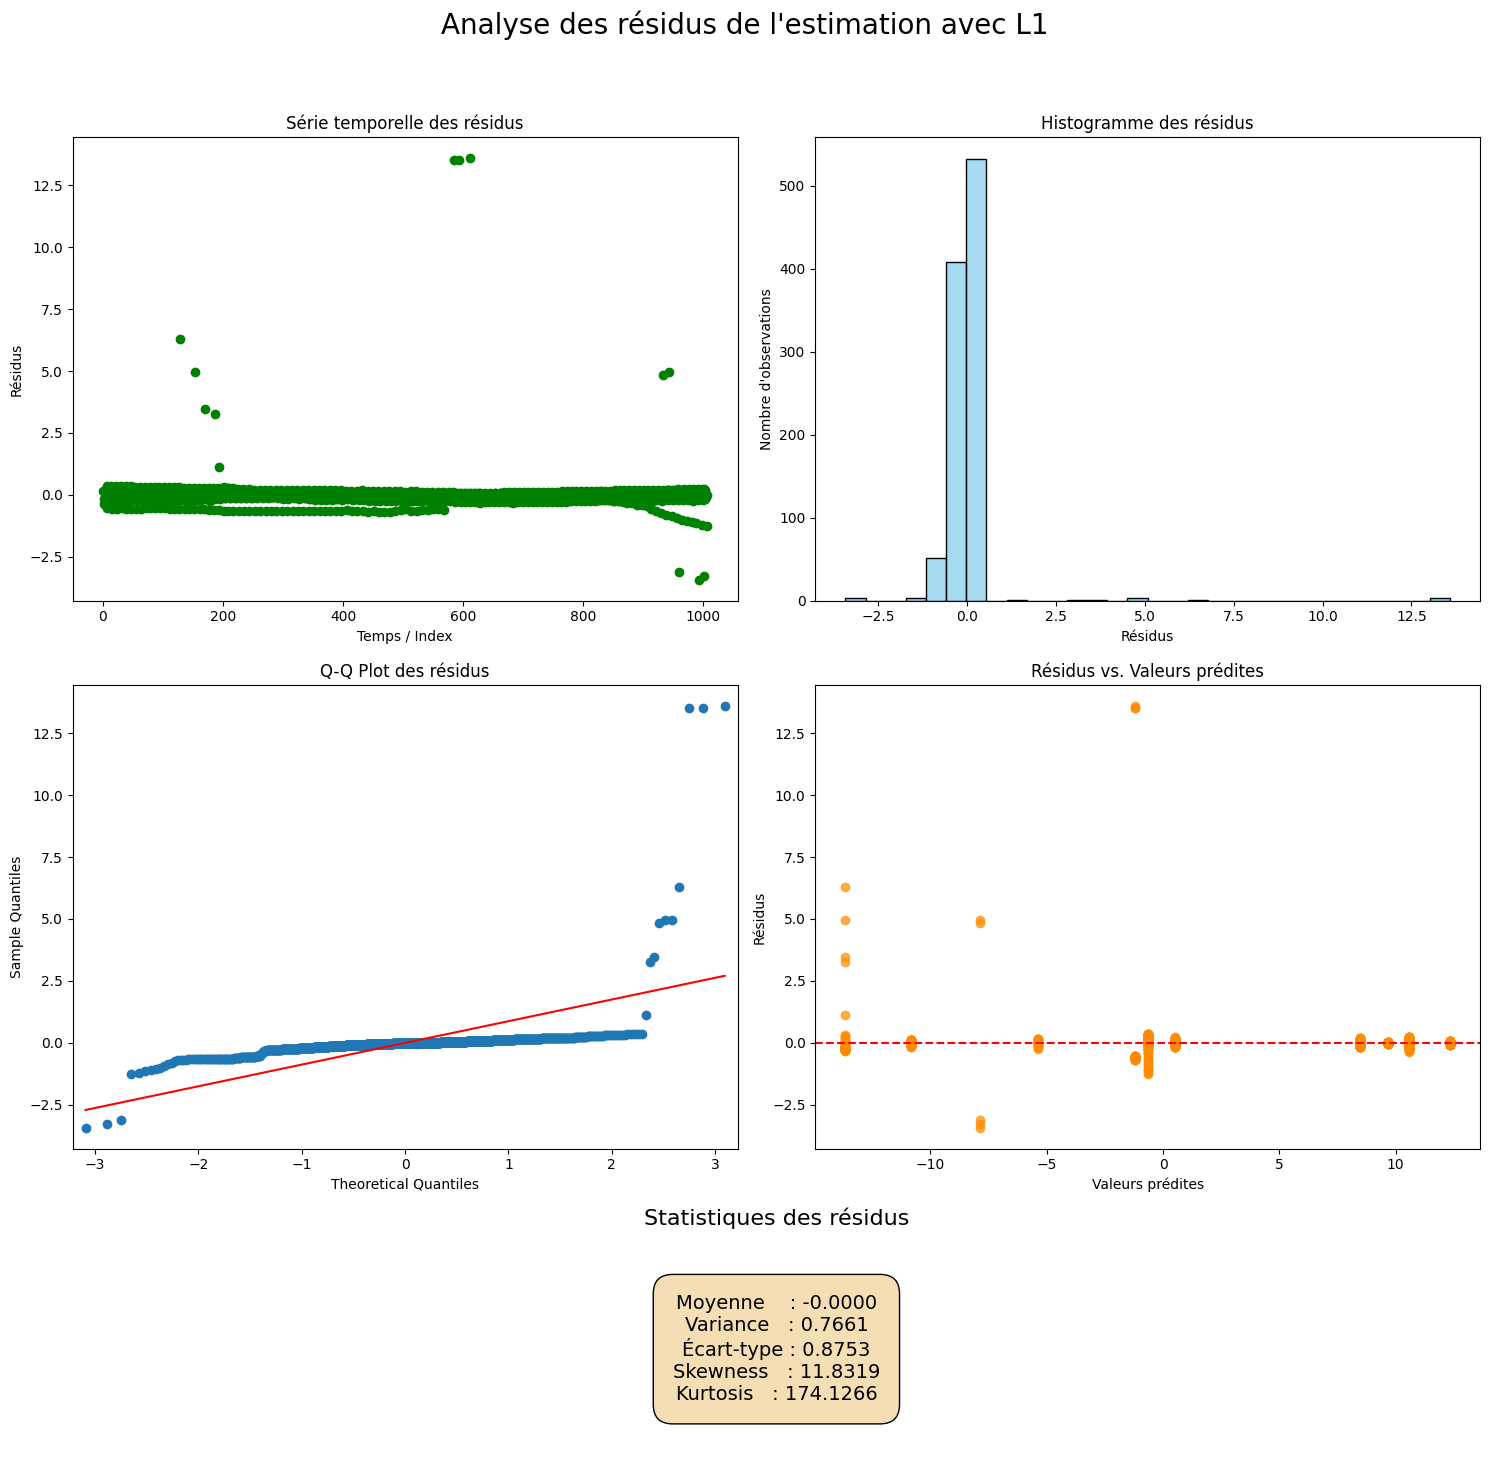

In [16]:
fig1 = plot_residual_analysis(Bchap_L1, Vchap_L1, figure_title="Analyse des résidus de l'estimation avec L1", save_path='PPMD_2025/Analyse_residusL1.png')

In [228]:
E, N, U = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2], P_chap_L1[0][0], P_chap_L1[1][0], P_chap_L1[2][0])
print(f"Easting : {E}, Northing : {N}, Up : {U}")
print(f"Distance : {np.sqrt((E)**2 + (N)**2 + (U)**2):.2f} m")

Easting : 1.3284338229410606, Northing : 0.04134394883996967, Up : -0.7927781008867207
Distance : 1.55 m


#### Wide Lane

P0 shape: (3, 1)
Iteration 1: sigma02 = 27.817502375541714
Iteration 2: sigma02 = 27.81750055115229
Iteration 3: sigma02 = 27.817500550846844
Résultat avec Wide-lane: [[4201791.26630718]
 [ 177952.76300553]
 [4779282.64967698]]
Figure sauvegardée dans : PPMD_2025/Analyse_residusWideLane.png


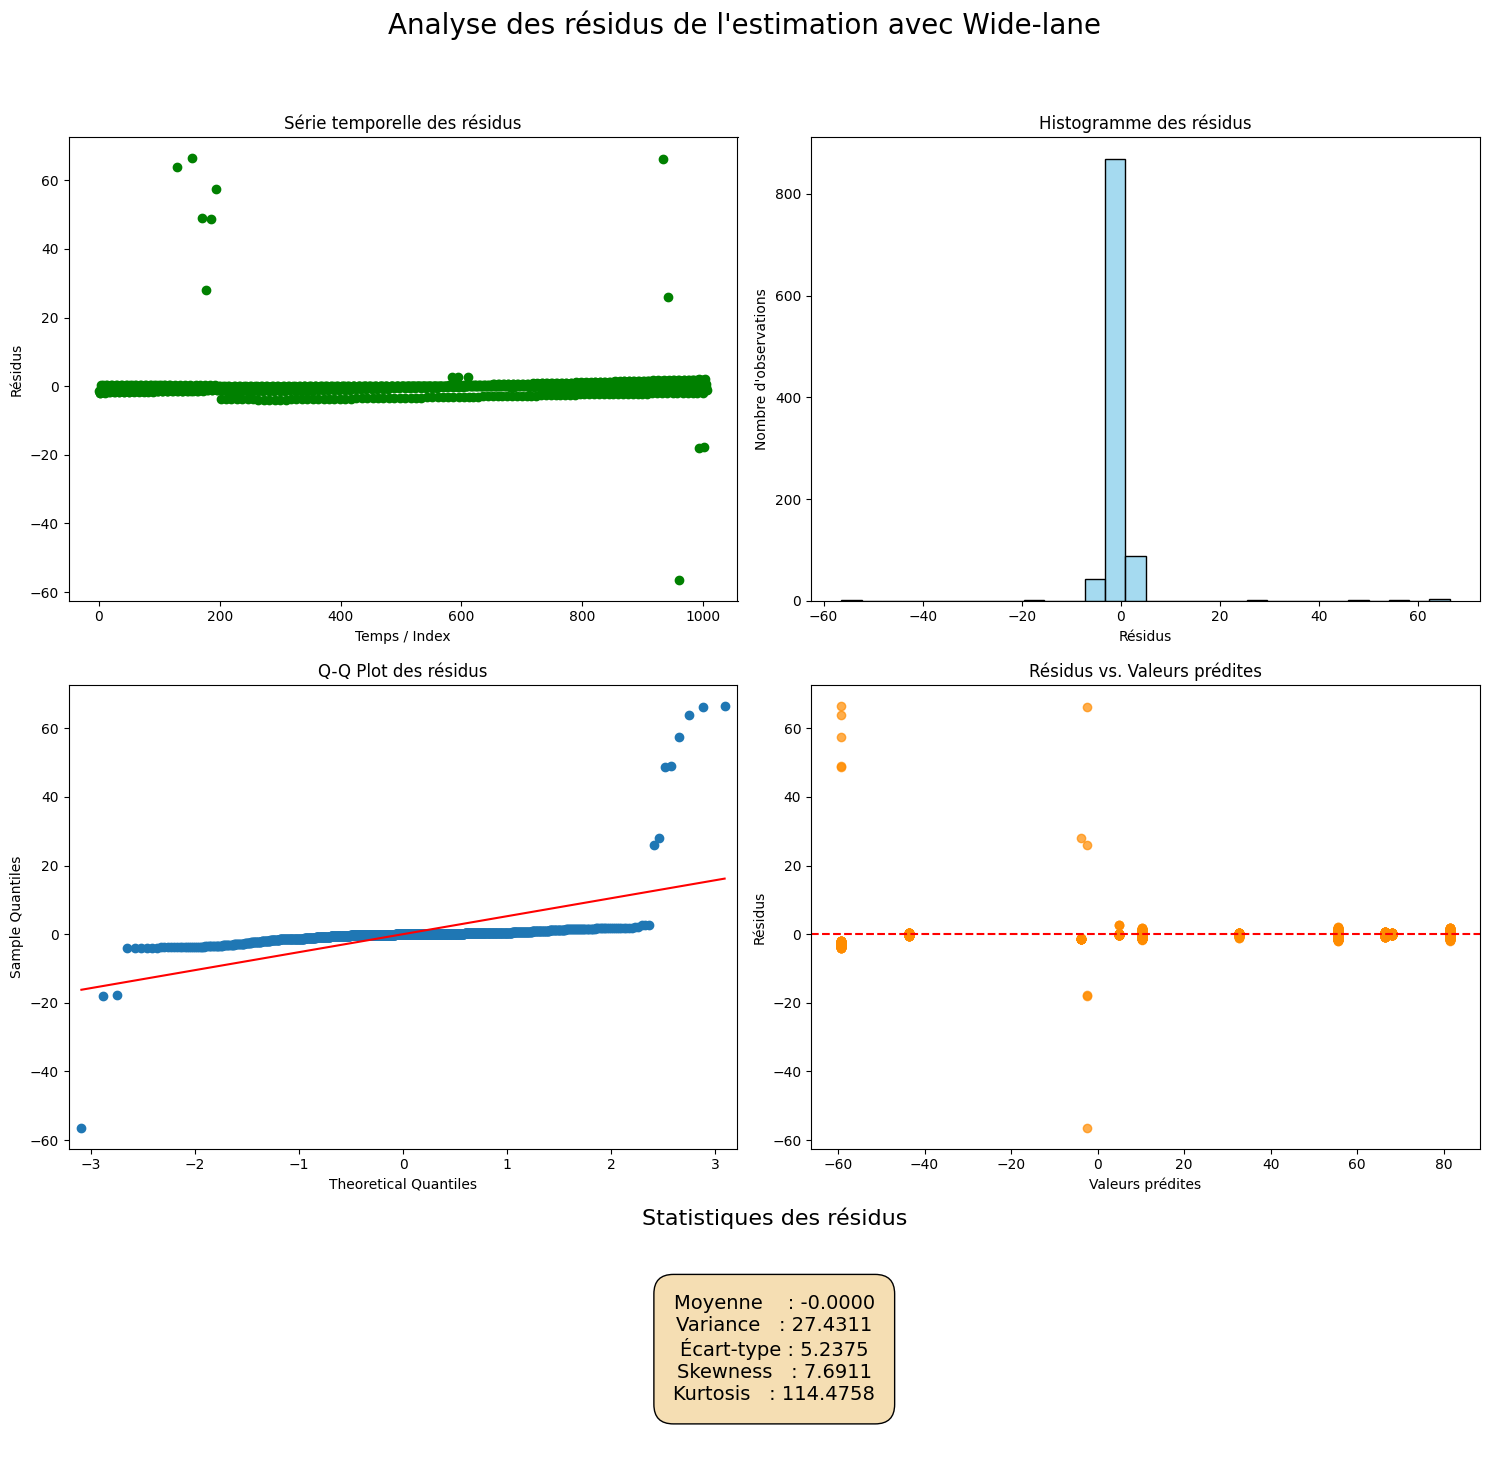

In [17]:
# Avec Wide-lane
P_chap_W, Vchap_W, sigma02_W, SigmaP_W, Bchap_W = double_difference(df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_W_m')
print("Résultat avec Wide-lane:", P_chap_W)
fig2 = plot_residual_analysis(Bchap_W, Vchap_W, figure_title="Analyse des résidus de l'estimation avec Wide-lane", save_path='PPMD_2025/Analyse_residusWideLane.png')

In [18]:
E, N, U = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2], P_chap_W[0][0], P_chap_W[1][0], P_chap_W[2][0])
print(f"Easting : {E}, Northing : {N}, Up : {U}")
print(f"Distance : {np.sqrt((E)**2 + (N)**2 + (U)**2):.2f} m")

Easting : 7.561792477797007, Northing : -2.1215628909070814, Up : -3.5051411506799215
Distance : 8.60 m


#### Narrow-Lane

P0 shape: (3, 1)
Iteration 1: sigma02 = 0.8241891053297359
Iteration 2: sigma02 = 0.8241889738820327
Résultat avec Narrow-lane: [[4201791.73855766]
 [ 177945.76988347]
 [4779286.54534746]]
Figure sauvegardée dans : PPMD_2025/Analyse_residusNarrowLane.png


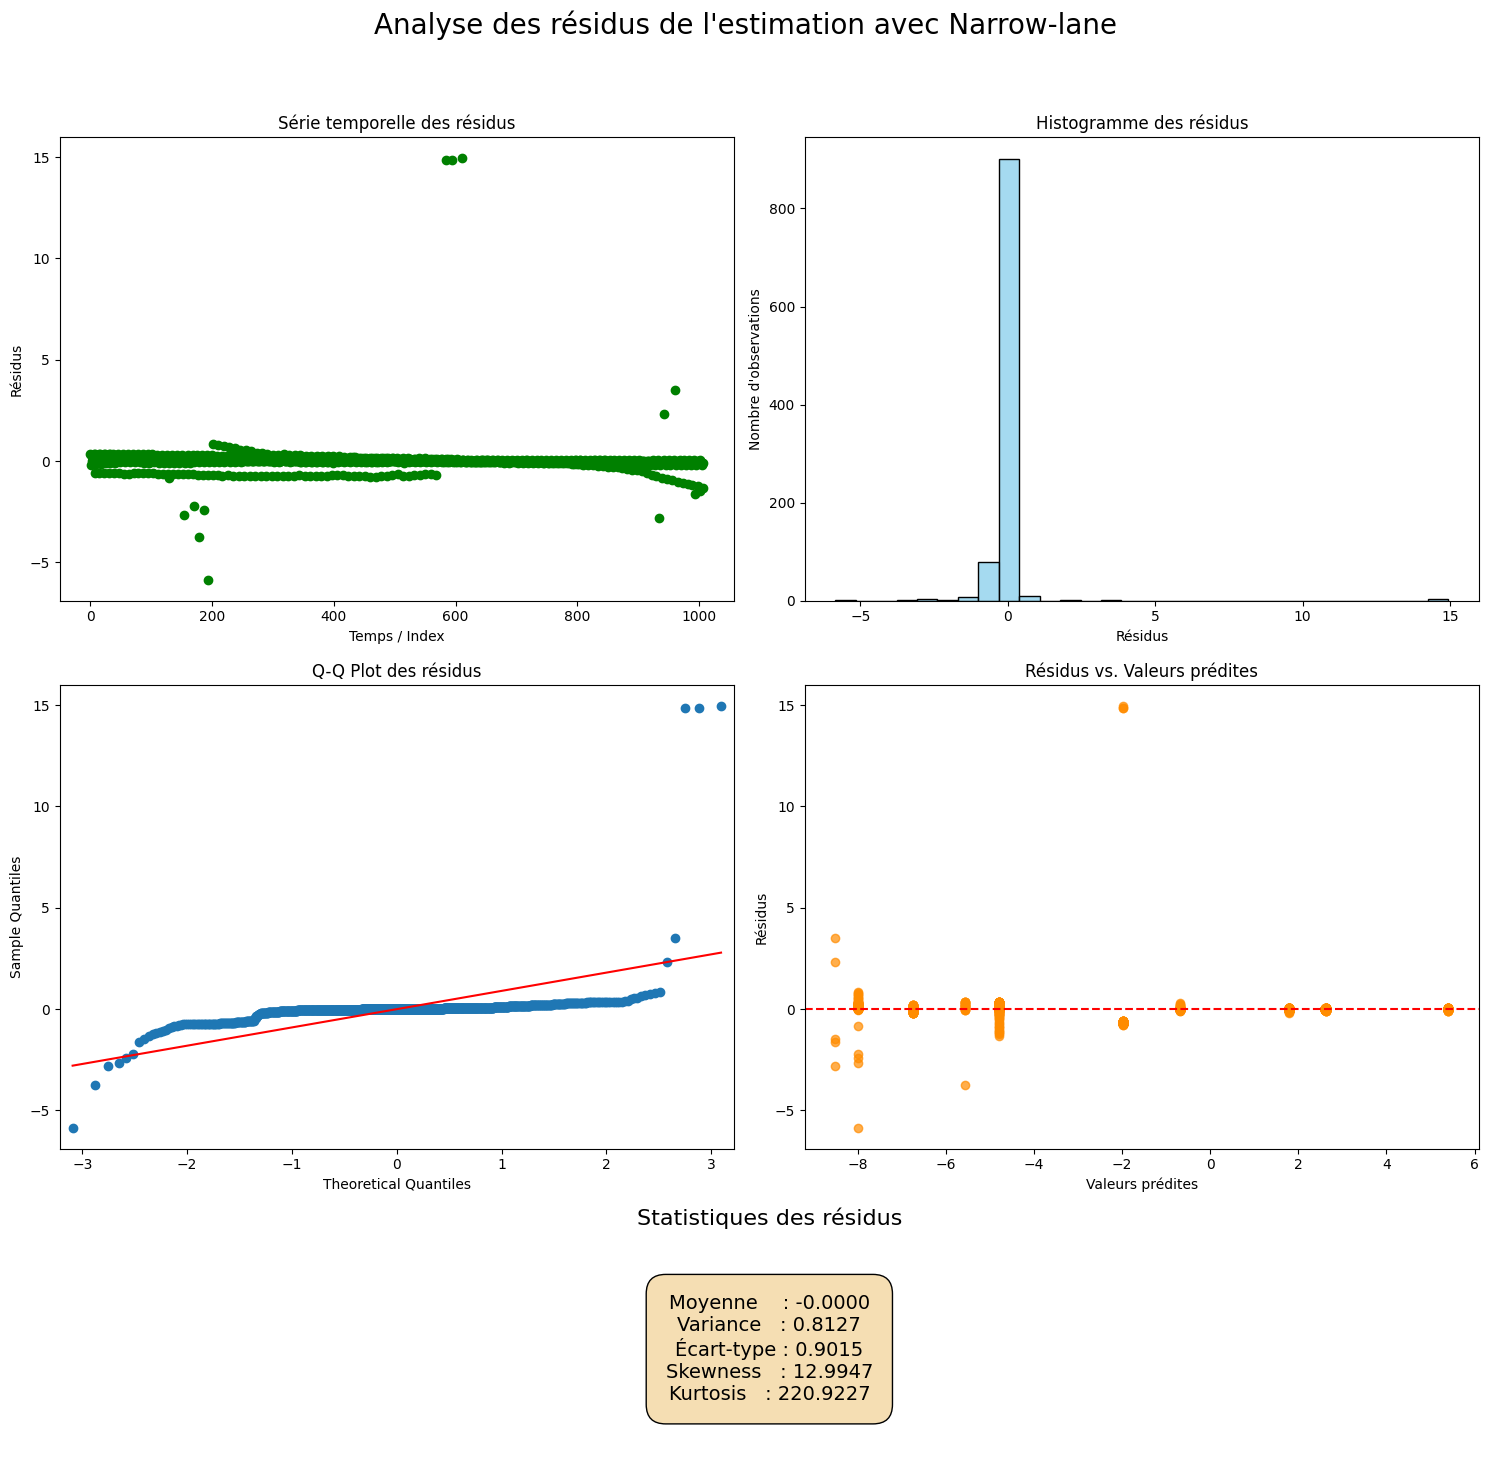

In [19]:
# Avec Narrow-lane
P_chap_N, Vchap_N, sigma02_N, SigmaP_N, Bchap_N = double_difference(df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_N_m')
print("Résultat avec Narrow-lane:", P_chap_N)
fig3 = plot_residual_analysis(Bchap_N, Vchap_N, figure_title="Analyse des résidus de l'estimation avec Narrow-lane", save_path='PPMD_2025/Analyse_residusNarrowLane.png')

In [20]:
E, N, U = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2], P_chap_N[0][0], P_chap_N[1][0], P_chap_N[2][0])
print(f"Easting : {E}, Northing : {N}, Up : {U}")
print(f"Distance : {np.sqrt((E)**2 + (N)**2 + (U)**2):.2f} m")

Easting : 0.5549512868223581, Northing : 0.3097337603328083, Up : -0.4562072009939351
Distance : 0.78 m


#### Résolution d'ambiguitees 

La méthode est la suivante : 
- Je fais une premiere estimation simultanée de la position et des ambiguités qui sont flottantes. J'utilise ensuite un arrondi à l'entier le plus proche pour "fixer" les ambiguitées à des valeurs entières. Une fois fait, je refais une estimation des positions à partir des ambiguitées entières. Pour se faire, je corrige le vecteur d'observarion B par les ambiguitées entiere et je ne refais que l'estimation des positions (matrice A).

In [21]:
def double_difference_with_ambiguity_resolution(df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_W_m'):
    P0 = P_rnx_header_Unknown.reshape(-1, 1)  # Position initiale du récepteur inconnu
    print("P0 shape:", P0.shape)

    # Intersection des index pour aligner les DataFrames
    common_index = df_rnxKnown_new.index.intersection(df_rnxUnknown_new.index)
    df_rnxKnown_new = df_rnxKnown_new.loc[common_index].copy()
    df_rnxUnknown_new = df_rnxUnknown_new.loc[common_index].copy()
    all_prn = np.unique(df_rnxKnown_new.index.get_level_values('prn'))
    epochs = np.unique(df_rnxKnown_new.index.get_level_values('epoch'))

    # Calcul des élévations pour choisir le satellite pivot
    ele_unknown, ele_known = [], []
    for epoch in epochs:
        df_epoch_unknown = df_rnxUnknown_new.loc[epoch]
        df_epoch_known = df_rnxKnown_new.loc[epoch]
        _, ele_k = tools.toolAzEle(P_rnx_header[0], P_rnx_header[1], P_rnx_header[2],
                                   df_epoch_known['X_sat'].values,
                                   df_epoch_known['Y_sat'].values,
                                   df_epoch_known['Z_sat'].values)
        ele_known.extend(ele_k)
        _, ele_u = tools.toolAzEle(P0[0, 0], P0[1, 0], P0[2, 0],
                                   df_epoch_unknown['X_sat'].values,
                                   df_epoch_unknown['Y_sat'].values,
                                   df_epoch_unknown['Z_sat'].values)
        ele_unknown.extend(ele_u)

    df_rnxUnknown_new['ele'] = ele_unknown
    df_rnxKnown_new['ele'] = ele_known

    # Étape 1 : Estimation flottante
    sigma02_old, sigma02, cpt = 0, 1e6, 0
    lambda_phase = {'L1m': gnss_const.lambda1, 'L_W_m': lambda_w, 'L_N_m': lambda_n}[phase_type]

    while np.abs(sigma02_old - sigma02) > 1e-6 and cpt < 10:
        dist_known = np.sqrt((df_rnxKnown_new['X_sat'] - P_rnx_header[0])**2 +
                             (df_rnxKnown_new['Y_sat'] - P_rnx_header[1])**2 +
                             (df_rnxKnown_new['Z_sat'] - P_rnx_header[2])**2)
        dist_Unknown = np.sqrt((df_rnxUnknown_new['X_sat'] - P0[0])**2 +
                               (df_rnxUnknown_new['Y_sat'] - P0[1])**2 +
                               (df_rnxUnknown_new['Z_sat'] - P0[2])**2)

        prn_pivot = df_rnxKnown_new.groupby('prn').filter(lambda x: len(x) == len(epochs)).groupby('prn')['ele'].mean().idxmax()
        indx_prn_pivot = df_rnxUnknown_new.index.get_level_values('prn') == prn_pivot

        matA = createMatA(epochs, prn_pivot, indx_prn_pivot, df_rnxUnknown_new, P_rnx_header, P0, dist_Unknown, all_prn)
        matB = createVecB(epochs, prn_pivot, indx_prn_pivot, df_rnxKnown_new, df_rnxUnknown_new, dist_known, dist_Unknown, phase_type)
        W = np.eye(len(matB))

        dP_float = np.linalg.inv(matA.T @ W @ matA) @ matA.T @ W @ matB
        P_chap = P0 + dP_float[:3].reshape(-1, 1)
        Vchap = matB - matA @ dP_float
        Bchap = matA @ dP_float

        n, p = matA.shape[0], matA.shape[1]
        sigma02_old = sigma02
        sigma02 = (Vchap.T @ W @ Vchap) / (n - p)

        P0 = P_chap
        cpt += 1
        print(f'Iteration {cpt}: sigma02 = {sigma02}')

    SigmaP_float = sigma02 * np.linalg.inv(matA.T @ W @ matA)
    N_float = dP_float[3:]  # Ambiguïtés flottantes

    # Étape 2 : Résolution des ambiguïtés Wide-lane
    if phase_type == 'L_W_m':
        N_fixed = np.round(N_float).astype(int)
        N_res = N_float - N_fixed
        print("Ambiguïtés Wide-lane fixées:", N_fixed)

        # Étape 3 : Ré-estimation avec ambiguïtés fixées
        matA_pos = matA[:, :3]
        matA_amb = matA[:, 3:]
        matB_fixed = matB - matA_amb @ (N_fixed * lambda_phase)  # Correction en mètres
        dP_fixed = np.linalg.inv(matA_pos.T @ W @ matA_pos) @ matA_pos.T @ W @ matB_fixed
        P_chap_fixed = P_rnx_header_Unknown.reshape(-1, 1) + dP_fixed.reshape(-1, 1)  # Utilisation de la position initiale + correction
        # P_chap_fixed = P_chap + dP_fixed.reshape(-1, 1)
        Vchap_fixed = matB_fixed - matA_pos @ dP_fixed
        sigma02_fixed = (Vchap_fixed.T @ W @ Vchap_fixed) / (matA_pos.shape[0] - matA_pos.shape[1])
        SigmaP_fixed = sigma02_fixed * np.linalg.inv(matA_pos.T @ W @ matA_pos)
    
        return P_chap_fixed, N_fixed, Vchap_fixed, sigma02_fixed, SigmaP_fixed, Bchap
    elif phase_type == 'L_N_m':
        N_fixed = np.round(N_float).astype(int)
        print("Ambiguïtés Narrow-lane flottantes:", N_float)
        print("Ambiguïtés Narrow-lane fixées:", N_fixed)
        N_res = N_float - N_fixed
        matA_pos = matA[:, :3]
        matA_amb = matA[:, 3:]
        matB_fixed = matB - matA_amb @ (N_fixed * lambda_phase)
        dP_fixed = np.linalg.inv(matA_pos.T @ W @ matA_pos) @ matA_pos.T @ W @ matB_fixed
        P_chap_fixed = P_rnx_header_Unknown.reshape(-1, 1) + dP_fixed.reshape(-1, 1)
        # P_chap_fixed = P_chap + dP_fixed.reshape(-1, 1)  # Utilise P_chap au lieu de P_rnx_header_Unknown
        Vchap_fixed = matB_fixed - matA_pos @ dP_fixed
        sigma02_fixed = (Vchap_fixed.T @ W @ Vchap_fixed) / (matA_pos.shape[0] - matA_pos.shape[1])
        SigmaP_fixed = sigma02_fixed * np.linalg.inv(matA_pos.T @ W @ matA_pos)
        return P_chap_fixed, N_fixed, Vchap_fixed, sigma02_fixed, SigmaP_fixed, Bchap
    else:
        return P_chap, N_float, Vchap, sigma02, SigmaP_float, Bchap
    
############################# Ici ma tentative de propagation de Melbourne-Wubbena dans Wide Lane et Narrow-lane #############################

# def double_difference_with_ambiguity_resolution(df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_W_m'):
#     P0 = P_rnx_header_Unknown.reshape(-1, 1)
#     print("P0 shape:", P0.shape)

#     common_index = df_rnxKnown_new.index.intersection(df_rnxUnknown_new.index)
#     df_rnxKnown_new = df_rnxKnown_new.loc[common_index].copy()
#     df_rnxUnknown_new = df_rnxUnknown_new.loc[common_index].copy()
#     all_prn = np.unique(df_rnxKnown_new.index.get_level_values('prn'))
#     epochs = np.unique(df_rnxKnown_new.index.get_level_values('epoch'))

#     ele_unknown, ele_known = [], []
#     for epoch in epochs:
#         df_epoch_unknown = df_rnxUnknown_new.loc[epoch]
#         df_epoch_known = df_rnxKnown_new.loc[epoch]
#         _, ele_k = tools.toolAzEle(P_rnx_header[0], P_rnx_header[1], P_rnx_header[2],
#                                    df_epoch_known['X_sat'].values,
#                                    df_epoch_known['Y_sat'].values,
#                                    df_epoch_known['Z_sat'].values)
#         ele_known.extend(ele_k)
#         _, ele_u = tools.toolAzEle(P0[0, 0], P0[1, 0], P0[2, 0],
#                                    df_epoch_unknown['X_sat'].values,
#                                    df_epoch_unknown['Y_sat'].values,
#                                    df_epoch_unknown['Z_sat'].values)
#         ele_unknown.extend(ele_u)

#     df_rnxUnknown_new['ele'] = ele_unknown
#     df_rnxKnown_new['ele'] = ele_known

#     sigma02_old, sigma02, cpt = 0, 1e6, 0
#     lambda_phase = {'L1m': gnss_const.lambda1, 'L_W_m': lambda_w, 'L_N_m': lambda_n}[phase_type]

#     while np.abs(sigma02_old - sigma02) > 1e-6 and cpt < 10:
#         dist_known = np.sqrt((df_rnxKnown_new['X_sat'] - P_rnx_header[0])**2 +
#                              (df_rnxKnown_new['Y_sat'] - P_rnx_header[1])**2 +
#                              (df_rnxKnown_new['Z_sat'] - P_rnx_header[2])**2)
#         dist_Unknown = np.sqrt((df_rnxUnknown_new['X_sat'] - P0[0])**2 +
#                                (df_rnxUnknown_new['Y_sat'] - P0[1])**2 +
#                                (df_rnxUnknown_new['Z_sat'] - P0[2])**2)

#         prn_pivot = df_rnxKnown_new.groupby('prn').filter(lambda x: len(x) == len(epochs)).groupby('prn')['ele'].mean().idxmax()
#         indx_prn_pivot = df_rnxUnknown_new.index.get_level_values('prn') == prn_pivot

#         matA = createMatA(epochs, prn_pivot, indx_prn_pivot, df_rnxUnknown_new, P_rnx_header, P0, dist_Unknown, all_prn)
#         matB = createVecB(epochs, prn_pivot, indx_prn_pivot, df_rnxKnown_new, df_rnxUnknown_new, dist_known, dist_Unknown, phase_type)
#         W = np.eye(len(matB))

#         dP_float = np.linalg.inv(matA.T @ W @ matA) @ matA.T @ W @ matB
#         P_chap = P0 + dP_float[:3].reshape(-1, 1)
#         Vchap = matB - matA @ dP_float
#         Bchap = matA @ dP_float

#         n, p = matA.shape[0], matA.shape[1]
#         sigma02_old = sigma02
#         sigma02 = (Vchap.T @ W @ Vchap) / (n - p)

#         P0 = P_chap
#         cpt += 1
#         print(f'Iteration {cpt}: sigma02 = {sigma02}')

#     SigmaP_float = sigma02 * np.linalg.inv(matA.T @ W @ matA)
#     N_float = dP_float[3:] / lambda_phase  # Ambiguïtés flottantes en cycles

#     matA_pos = matA[:, :3]
#     matA_amb = matA[:, 3:]
#     non_pivot_prns = all_prn[all_prn != prn_pivot]

#     if phase_type == 'L_W_m':
#         N_W_fixed, prn_unique = compute_melbourne_wubbena(df_rnxKnown_new, df_rnxUnknown_new)
#         N_fixed = np.zeros(matA_amb.shape[1], dtype=int)
#         for i, prn in enumerate(non_pivot_prns):
#             idx = np.where(prn_unique == prn)[0]
#             if len(idx) > 0:
#                 N_fixed[i] = N_W_fixed[idx[0]]
#         print(f"Ambiguïtés Wide-lane flottantes: {N_float}")
#         print(f"Ambiguïtés Wide-lane fixées via MW: {N_fixed}")
#         print(f"Satellites non-pivot: {non_pivot_prns}")

#         matB_fixed = matB - matA_amb @ (N_fixed * lambda_w)
#         dP_fixed = np.linalg.inv(matA_pos.T @ W @ matA_pos) @ matA_pos.T @ W @ matB_fixed
#         P_chap_fixed = P_rnx_header_Unknown.reshape(-1, 1) + dP_fixed.reshape(-1, 1)
#         Vchap_fixed = matB_fixed - matA_pos @ dP_fixed
#         sigma02_fixed = (Vchap_fixed.T @ W @ Vchap_fixed) / (matA_pos.shape[0] - matA_pos.shape[1])
#         SigmaP_fixed = sigma02_fixed * np.linalg.inv(matA_pos.T @ W @ matA_pos)
        
#         return P_chap_fixed, N_fixed, Vchap_fixed, sigma02_fixed, SigmaP_fixed, Bchap

#     elif phase_type == 'L_N_m':
#         N_W_fixed, prn_unique = compute_melbourne_wubbena(df_rnxKnown_new, df_rnxUnknown_new)
#         N_fixed_W_aligned = np.zeros(matA_amb.shape[1], dtype=int)
#         for i, prn in enumerate(non_pivot_prns):
#             idx = np.where(prn_unique == prn)[0]
#             if len(idx) > 0:
#                 N_fixed_W_aligned[i] = N_W_fixed[idx[0]]
        
#         matB_W = createVecB(epochs, prn_pivot, indx_prn_pivot, df_rnxKnown_new, df_rnxUnknown_new, dist_known, dist_Unknown, 'L_W_m')
#         N_W_float_full = (matB_W - matA_pos @ dP_float[:3]) / lambda_w
#         prn_array = np.array([df_rnxUnknown_new.index.get_level_values('prn')[i] for i in range(len(matB_W))])
#         N_W_float = np.zeros(len(non_pivot_prns))
#         for i, prn in enumerate(non_pivot_prns):
#             mask = prn_array == prn
#             if np.sum(mask) > 0:
#                 N_W_float[i] = np.mean(N_W_float_full[mask])
#             else:
#                 N_W_float[i] = 0
        
#         correction_W = N_W_float - N_fixed_W_aligned
        
#         # Réduire N_float correctement pour Narrow-lane
#         N_N_float = N_float  # N_float est déjà par satellite (taille 11)
#         N_N_adjusted = N_N_float - (f1 * correction_W) / (f1 - f2)
#         N_fixed = np.round(N_N_adjusted).astype(int)
        
#         print(f"Ambiguïtés Wide-lane flottantes ajustées: {N_W_float}")
#         print(f"Ambiguïtés Wide-lane fixées via MW: {N_fixed_W_aligned}")
#         print(f"Correction Wide-lane: {correction_W}")
#         print(f"Ambiguïtés Narrow-lane flottantes: {N_N_float}")
#         print(f"Ambiguïtés Narrow-lane ajustées: {N_N_adjusted}")
#         print(f"Ambiguïtés Narrow-lane fixées: {N_fixed}")
#         print(f"Satellites non-pivot: {non_pivot_prns}")

#         matB_fixed = matB - matA_amb @ (N_fixed * lambda_n)
#         dP_fixed = np.linalg.inv(matA_pos.T @ W @ matA_pos) @ matA_pos.T @ W @ matB_fixed
#         P_chap_fixed = P_rnx_header_Unknown.reshape(-1, 1) + dP_fixed.reshape(-1, 1)
#         Vchap_fixed = matB_fixed - matA_pos @ dP_fixed
#         sigma02_fixed = (Vchap_fixed.T @ W @ Vchap_fixed) / (matA_pos.shape[0] - matA_pos.shape[1])
#         SigmaP_fixed = sigma02_fixed * np.linalg.inv(matA_pos.T @ W @ matA_pos)
        
#         return P_chap_fixed, N_fixed, Vchap_fixed, sigma02_fixed, SigmaP_fixed, Bchap

#     else:
#         return P_chap, N_float, Vchap, sigma02, SigmaP_float, Bchap

##### Cellule de test avec la propagation de Melbourne Wubbena

In [ ]:
# # Wide-lane avec Melbourne-Wübbena
# P_chap_W, N_fixed_W, Vchap_W, sigma02_W, SigmaP_W, Bchap_W = double_difference_with_ambiguity_resolution(
#     df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_W_m'
# )
# E_W, N_W, U_W = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2],
#                                        P_chap_W[0][0], P_chap_W[1][0], P_chap_W[2][0])
# distance_W = np.sqrt(E_W**2 + N_W**2 + U_W**2)
# print(f"Position Wide-lane fixée (MW): {P_chap_W}")
# print(f"Distance Wide-lane fixée (MW): {distance_W:.2f} m")
# print(f"Easting: {E_W:.3f}, Northing: {N_W:.3f}, Up: {U_W:.3f}")

# # Narrow-lane utilisant Wide-lane
# P_chap_N, N_fixed_N, Vchap_N, sigma02_N, SigmaP_N, Bchap_N = double_difference_with_ambiguity_resolution(
#     df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_N_m'
# )
# E_N, N_N, U_N = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2],
#                                        P_chap_N[0][0], P_chap_N[1][0], P_chap_N[2][0])
# distance_N = np.sqrt(E_N**2 + N_N**2 + U_N**2)
# print(f"Position Narrow-lane fixée (MW): {P_chap_N}")
# print(f"Distance Narrow-lane fixée (MW): {distance_N:.2f} m")
# print(f"Easting: {E_N:.3f}, Northing: {N_N:.3f}, Up: {U_N:.3f}")

P0 shape: (3, 1)
Iteration 1: sigma02 = 27.817502375541714
Iteration 2: sigma02 = 27.81750055115229
Iteration 3: sigma02 = 27.817500550846844
Ambiguïtés MW flottantes: [  -5.00223752  -10.97545359   72.41077936 -104.92851711  -11.06804937
  -74.92689242   45.11516976  -82.99805683  -73.9292144   -52.0864753
  -12.24201336]
Écart-type MW: [ 7.13722555  0.79651792 15.47632416  0.59105555 48.94523165  0.49839272
  0.33835237  0.33495611  0.37347626  0.62991678  0.78294459]
Ambiguïtés MW fixées (filtrées): [ -11 -105  -75   45  -83  -74  -52  -12]
Satellites correspondants (filtrés): ['G07' 'G10' 'G20' 'G21' 'G26' 'G27' 'G29' 'G31']
Ambiguïtés Wide-lane flottantes: [ -4.42740557  11.84095339 -68.68098611  94.36441517  -2.87568716
  64.54201635 -50.66397408  78.98798037  77.10913725  37.94597531
   5.85266883]
Ambiguïtés Wide-lane fixées via MW: [   0  -11    0 -105    0  -75   45  -83  -74  -52  -12]
Satellites non-pivot: ['G05' 'G07' 'G08' 'G10' 'G15' 'G20' 'G21' 'G26' 'G27' 'G29' 'G31']


##### Avec Wide-Lane

In [22]:
# Appel pour Wide-lane
P_chap_W, N_fixed_W, Vchap_W, sigma02_W, SigmaP_W, Bchap_W = double_difference_with_ambiguity_resolution(
    df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_W_m'
)
print("Position finale (Wide-lane fixée):", P_chap_W)
print("Ambiguïtés Wide-lane fixées:", N_fixed_W)



P0 shape: (3, 1)
Iteration 1: sigma02 = 27.817502375541714
Iteration 2: sigma02 = 27.81750055115229
Iteration 3: sigma02 = 27.817500550846844
Ambiguïtés Wide-lane fixées: [ -4  10 -59  81  -2  56 -44  68  66  33   5]
Position finale (Wide-lane fixée): [[4201794.02017824]
 [ 177947.62748532]
 [4779281.60990838]]
Ambiguïtés Wide-lane fixées: [ -4  10 -59  81  -2  56 -44  68  66  33   5]


Figure sauvegardée dans : PPMD_2025/Analyse_residusWideLane_fixed.png


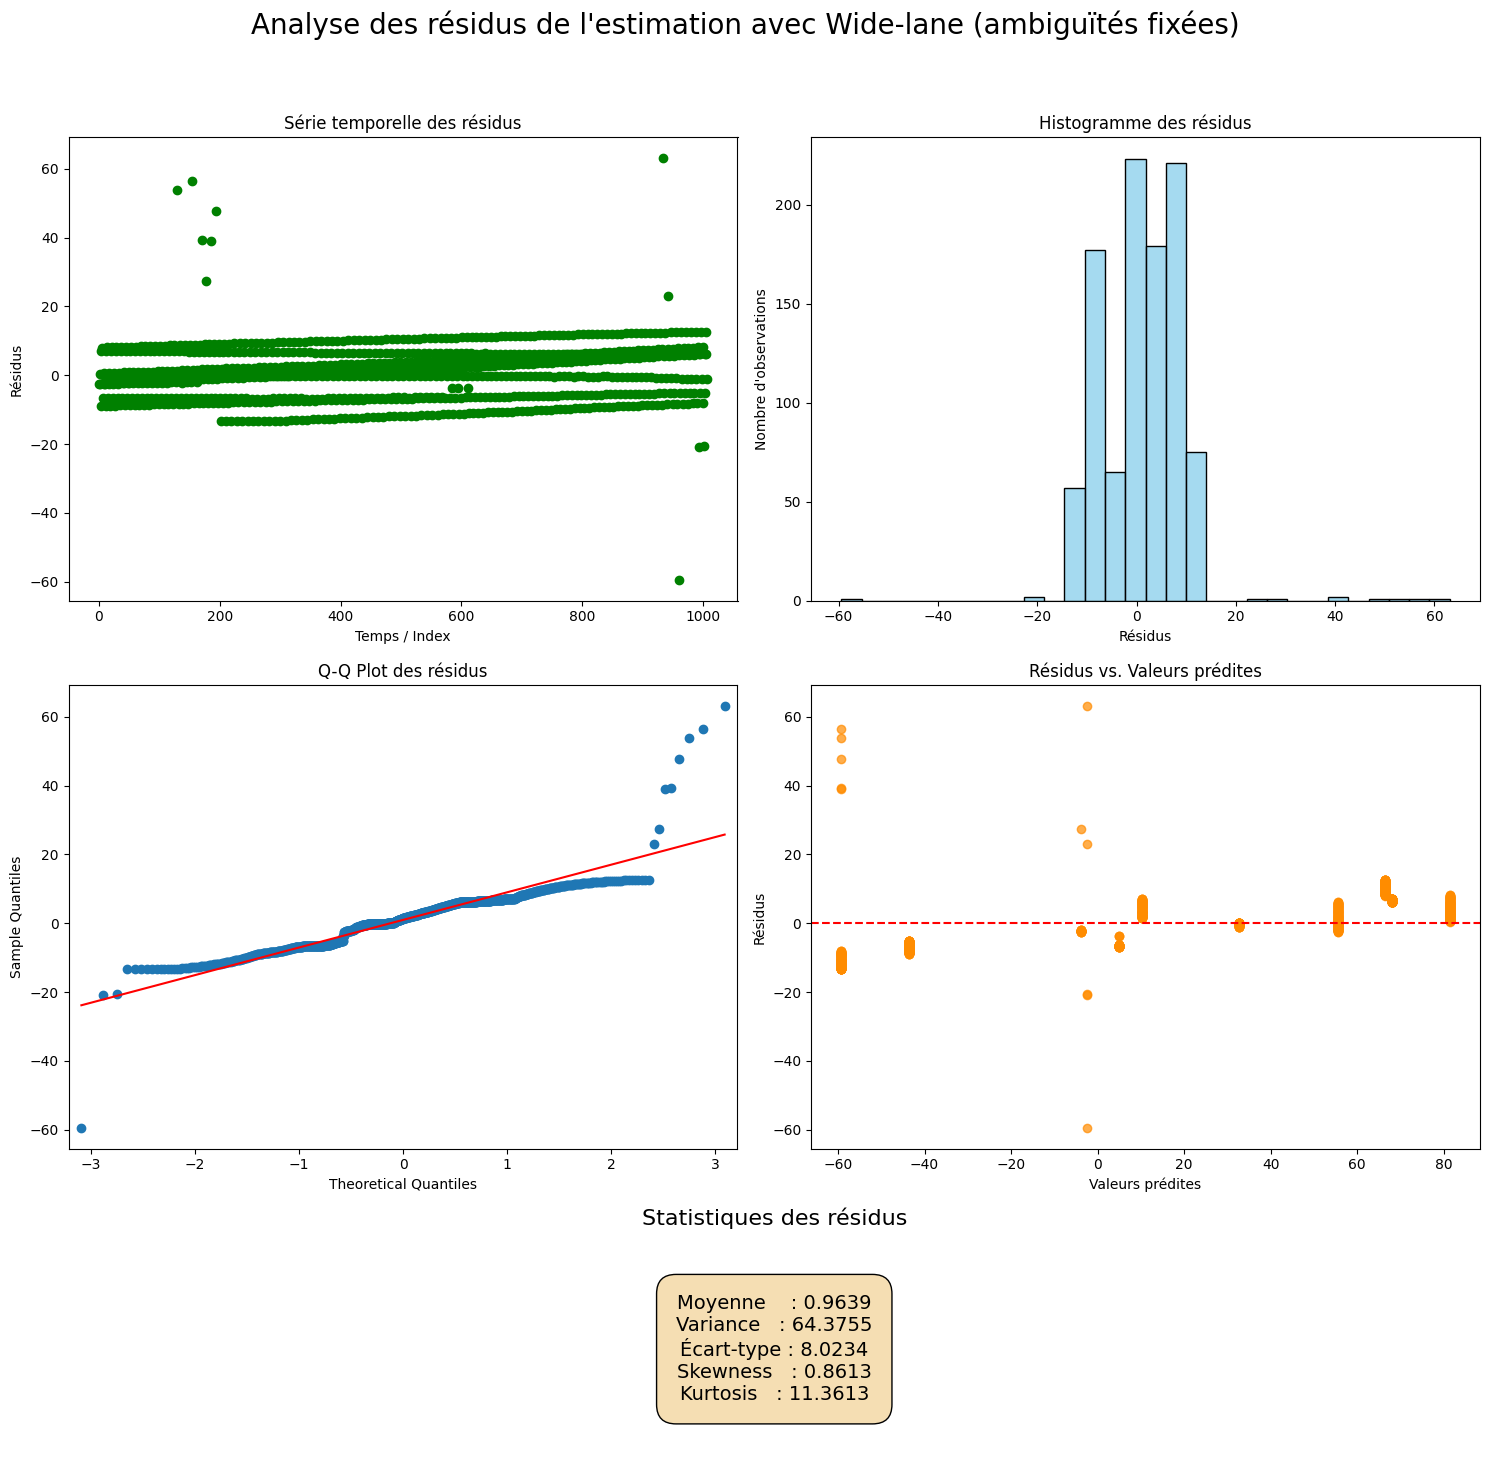

In [23]:
fig4 = plot_residual_analysis(Bchap_W, Vchap_W, figure_title="Analyse des résidus de l'estimation avec Wide-lane (ambiguïtés fixées)", save_path='PPMD_2025/Analyse_residusWideLane_fixed.png')

In [24]:
# Calcul des différences ENU
E, N, U = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2],
                                 P_chap_W[0][0], P_chap_W[1][0], P_chap_W[2][0])
print(f"Easting: {E}, Northing: {N}, Up: {U}")
print(f"Distance: {np.sqrt(E**2 + N**2 + U**2):.2f} m")

Easting: 2.3143498244384393, Northing: -4.713837625518642, Up: -2.6202966995251273
Distance: 5.87 m


##### Pour Narrow-Lane

In [25]:
P_chap_N, N_fixed_N, Vchap_N, sigma02_N, SigmaP_N, Bchap_N = double_difference_with_ambiguity_resolution(
    df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L_N_m'
)


P0 shape: (3, 1)
Iteration 1: sigma02 = 0.8241891053297359
Iteration 2: sigma02 = 0.8241889738820327
Ambiguïtés Narrow-lane flottantes: [-5.55700347 -0.6954167  -7.99148838  1.78248792 -8.50889692  2.610868
 -6.74351388  5.4046411   2.62038163 -4.79747636 -1.98770956]
Ambiguïtés Narrow-lane fixées: [-6 -1 -8  2 -9  3 -7  5  3 -5 -2]


Figure sauvegardée dans : PPMD_2025/Analyse_residusNarrowLane_fixed.png


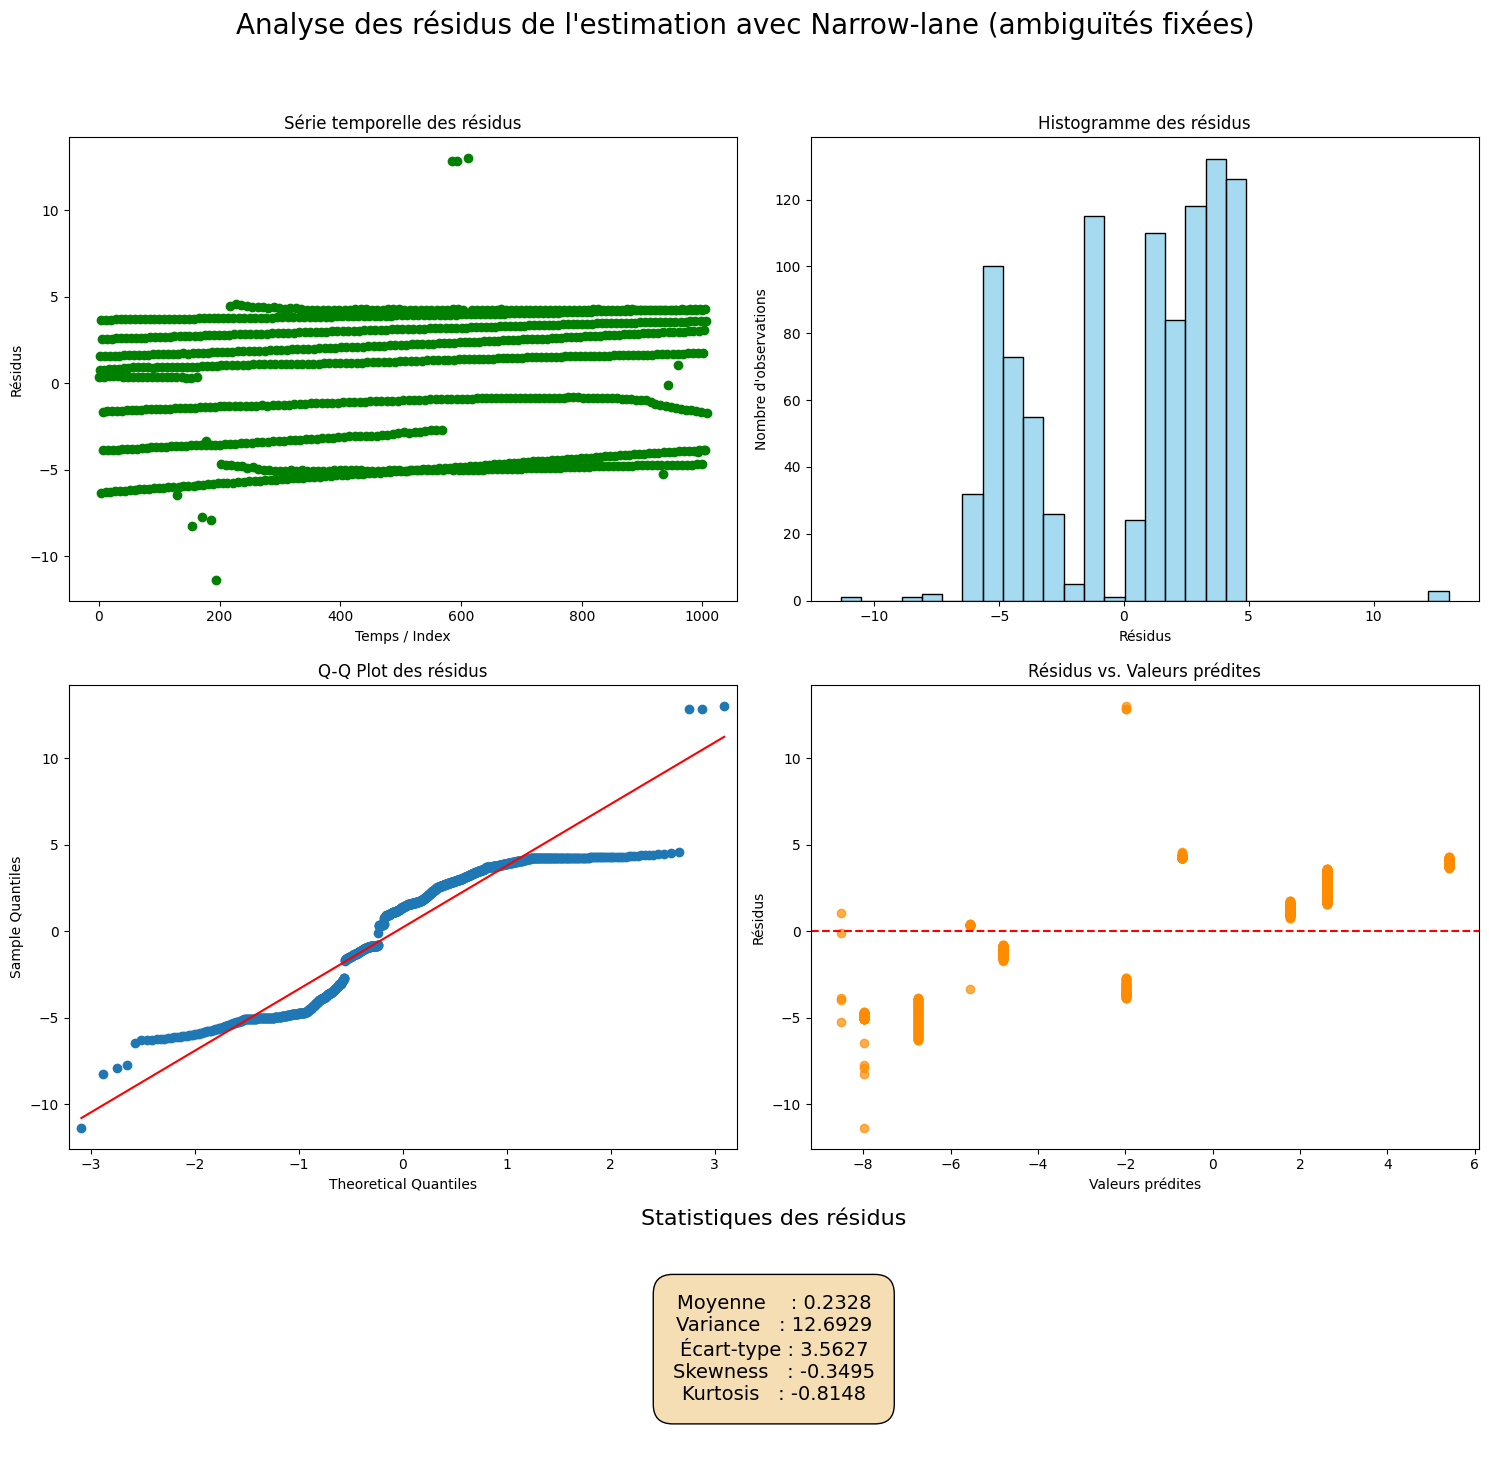

In [26]:
fig5 = plot_residual_analysis(Bchap_N, Vchap_N, figure_title="Analyse des résidus de l'estimation avec Narrow-lane (ambiguïtés fixées)", save_path='PPMD_2025/Analyse_residusNarrowLane_fixed.png')

In [27]:
E, N, U = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2],
                                 P_chap_N[0][0], P_chap_N[1][0], P_chap_N[2][0])
print(f"Narrow-lane - Easting: {E}, Northing: {N}, Up: {U}")
print(f"Distance: {np.sqrt(E**2 + N**2 + U**2):.2f} m")

Narrow-lane - Easting: -0.7136525073116935, Northing: -2.953430409180626, Up: 2.7999063789629557
Distance: 4.13 m


#### Ambiguitées flottante (pas fixé par les combinaison WL ou NL)

In [28]:
P_chap_L1, N_float_L1, Vchap_L1, sigma02_L1, SigmaP_L1, Bchap_L1 = double_difference_with_ambiguity_resolution(
    df_rnxKnown_new, df_rnxUnknown_new, P_rnx_header, P_rnx_header_Unknown, phase_type='L1m'
)
E, N, U = tools.toolCartLocGRS80(P_rnx_header_Unknown[0], P_rnx_header_Unknown[1], P_rnx_header_Unknown[2],
                                 P_chap_L1[0][0], P_chap_L1[1][0], P_chap_L1[2][0])
print(f"L1 flottante - Easting: {E}, Northing: {N}, Up: {U}")
print(f"Distance: {np.sqrt(E**2 + N**2 + U**2):.2f} m")

P0 shape: (3, 1)
Iteration 1: sigma02 = 0.7768756234645808
Iteration 2: sigma02 = 0.7768753017126742
L1 flottante - Easting: 1.3284338229410606, Northing: 0.04134394883996967, Up: -0.7927781008867207
Distance: 1.55 m


##### Analyse des resultats.

Avec la double différence, les différences entre l'estimation et la position de la valeur approché du rinex sont :
- L1 flottantes : 1.55m
- Wilde-Lane : 8.60m
- Narrow-Lane : 0.78m

Avec la double différence avec les ambiguités fixées : 
- L1 flottantes : 1.55m
- Wilde-Lane : 5.87m
- Narrow-Lane : 4.13m

Lorsqu'on fait une ré-estimation de la position avec les ambiguitées fixés (entières) à partir d'une premiere estimation flottantes (L1), les positions s'eloignent de la solution lorsqu'on estime les ambiguités à des valeurs flottantes pour les combinaisons Melbourne Wübbena W-L et N-L. Je m'attendais à l'inverse. J'ai fais un affichage des ambiguités flottantes et entières pour regarder si les ambiguitées flottantes sont proche des entières. Cela est dans le but d'observer s'il y a du bruit, ou s'il le modèle de fixation est correct. Afin de voir si ce dernièr et correct, une étude des résidus est envisagable (ambiguite flottante - ambiguité fixé). 

En commentaire une version de la resolution d'ambiguité ou je les fixe en utilisant Melbourne-Wubbena que je tente de propager dans Wide Lane puis dans Narrow Lane. Ceci afin de corriger mes résultats précédent. Malheureusement j'obtient des valeurs incoherente...

